In [1]:
import pandas as pd
import numpy as np 
import statsmodels.api as sm
from scipy.optimize import minimize_scalar
import support_functions as sf
import statistical_analysis as sa
import importlib, support_functions, inspect, statistical_analysis
importlib.reload(support_functions)
importlib.reload(statistical_analysis)
# print('module file:', support_functions.__file__)
# print(inspect.getsource(support_functions.change_product_name)[:400])
# from pygam import glm, s, f, te, PoissonGAM, ExponentialGAM, ExpectileGAM
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

path = Path("data") / "ml_task_data.csv"
raw_data = pd.read_csv(path)
# raw_data.sample(3)

In [2]:
# Preprocess data and reorganise into separate dataframes per product
df, df_product_A, df_product_B, df_product_C, df_product_D, df_product_E = support_functions.rawDataReorganise(raw_data)
dfs = [df_product_A, df_product_B, df_product_C, df_product_D, df_product_E]
products=['A', 'B', 'C', 'D', 'E']
df.head()

,product_id,sell_price,margin,sales,revenue,cost
date,,,,,,
2019-01-01,product_A,82.39,24.72,19,1565.41,57.67
2019-01-01,product_C,65.89,19.77,8,527.12,46.12
2019-01-01,product_B,36.19,10.86,6,217.14,25.33
2019-01-01,product_D,43.89,13.17,1,43.89,30.72
2019-01-02,product_C,65.89,19.77,26,1713.14,46.12


In [3]:
df_product_A.head()

,product_id,sell_price,margin,sales,revenue,cost
date,,,,,,
2019-01-01,product_A,82.39,24.72,19,1565.41,57.67
2019-01-02,product_A,82.39,24.72,41,3377.99,57.67
2019-01-03,product_A,82.39,24.72,66,5437.74,57.67
2019-01-04,product_A,82.39,24.72,77,6344.03,57.67
2019-01-05,product_A,82.39,24.72,77,6344.03,57.67


#### Create Weekly data

In [4]:
dfs = [df_product_A, df_product_B, df_product_C, df_product_D, df_product_E]
products=['A', 'B', 'C', 'D', 'E']


[df_weekly_A, df_weekly_B, df_weekly_C, df_weekly_D, df_weekly_E] = sf.create_weekly_data_all_products(dfs=dfs, products=products)
dfs_weekly = [df_weekly_A, df_weekly_B, df_weekly_C, df_weekly_D, df_weekly_E]
df_weekly_A.head()

,sales,sell_price,margin,revenue,cost,running_week,product_id
date,,,,,,,
2019-01-06,350,82.39,24.72,28836.50,57.67,1,A
2019-01-13,422,82.21,24.66,34691.70,57.54,2,A
2019-01-20,386,82.39,24.72,31802.54,57.67,3,A
2019-01-27,1019,66.02,19.81,67274.71,46.21,4,A
2019-02-03,349,82.39,24.72,28754.11,57.67,5,A


## Daily and Weekly Summary

In [5]:
sf.product_sales_summary(dfs=dfs, products=products)

Sales Date Range by Product:
Product FirstSaleDate LastSaleDate  TotalDays  DaysWithSales  DaysWithNoSales
      A    2019-01-01   2021-01-27        758            755                3
      B    2019-01-01   2021-01-27        758            739               19
      C    2019-01-01   2021-01-27        758            737               21
      D    2019-01-01   2021-01-27        758            677               81
      E    2019-04-10   2021-01-27        659            645               14

Sales Summary by Product:
Product  TotalSales  AvgDailySales  MaxDailySales  MinDailySales  StdDevofDailySales  AvgSalePrice  AvgMargin   AvgRevenue
      A       66727      88.380132           1371              2          114.811724     91.594993  27.481338  6951.440993
      B       69728      94.354533           1109              6          147.750637     35.526631  10.660798  2846.385264
      C       66976      90.876526            694              5          108.135054     63.578141  19.0762

In [6]:
# Create sales week range from dfs_weekly
products = ['A', 'B', 'C', 'D', 'E']
sales_week_range = []

for product, df_weekly in zip(products, dfs_weekly):
    # Extract year-week from index
    df_weekly_copy = df_weekly.copy()
    df_weekly_copy['year_week'] = df_weekly_copy.index.isocalendar().year.astype(str) + '-W' + df_weekly_copy.index.isocalendar().week.astype(str).str.zfill(2)
    
    unique_weeks = df_weekly_copy['year_week'].unique()
    first_week = unique_weeks[0]
    last_week = unique_weeks[-1]
    weeks_with_sales = len(unique_weeks)
    
    # Calculate total weeks from first to last
    first_date = df_weekly.index.min()
    last_date = df_weekly.index.max()
    total_weeks = ((last_date - first_date).days // 7) + 1
    weeks_no_sales = total_weeks - weeks_with_sales
    
    sales_week_range.append({
        'Product': product,
        'First Sales Week': first_week,
        'Last Sales Week': last_week,
        'Total Weeks': total_weeks,
        'Weeks with Sales': weeks_with_sales,
        'Weeks with No Sales': weeks_no_sales
    })

sales_week_df_weekly = pd.DataFrame(sales_week_range)
print("Sales Week Range by Product (from dfs_weekly):")
print(sales_week_df_weekly.to_string(index=False))
# sales_week_df_weekly

Sales Week Range by Product (from dfs_weekly):
Product First Sales Week Last Sales Week  Total Weeks  Weeks with Sales  Weeks with No Sales
      A         2019-W01        2021-W04          109               109                    0
      B         2019-W01        2021-W04          109               109                    0
      C         2019-W01        2021-W04          109               109                    0
      D         2019-W01        2021-W04          109               109                    0
      E         2019-W15        2021-W04           95                95                    0


### Wide Data Form

In [7]:
dfs = [df_product_A, df_product_B, df_product_C, df_product_D, df_product_E]
products=['A', 'B', 'C', 'D', 'E']
for df, product in zip(dfs, products):
    globals()[f'df_product_{product}'] = sf.change_column_names(df, product)
df_product_A

Column running_week not found in            product_id  sell_price_A  margin_A  sales_A  revenue_A  cost_A  \
date                                                                        
2019-01-01  product_A         82.39     24.72       19    1565.41   57.67   
2019-01-02  product_A         82.39     24.72       41    3377.99   57.67   
2019-01-03  product_A         82.39     24.72       66    5437.74   57.67   
2019-01-04  product_A         82.39     24.72       77    6344.03   57.67   
2019-01-05  product_A         82.39     24.72       77    6344.03   57.67   
...               ...           ...       ...      ...        ...     ...   
2021-01-23  product_A         98.89     29.67       32    3164.48   69.22   
2021-01-24  product_A         98.89     29.67       29    2867.81   69.22   
2021-01-25  product_A         98.89     29.67       53    5241.17   69.22   
2021-01-26  product_A         98.89     29.67       47    4647.83   69.22   
2021-01-27  product_A         98.89     29.

,sell_price_A,margin_A,sales_A,revenue_A,cost_A,log_sell_price_A,log_sales_A,log_revenue_A
date,,,,,,,,
2019-01-01,82.39,24.72,19,1565.41,57.67,4.423528,2.995732,7.356542
2019-01-02,82.39,24.72,41,3377.99,57.67,4.423528,3.737670,8.125332
2019-01-03,82.39,24.72,66,5437.74,57.67,4.423528,4.204693,8.601303
2019-01-04,82.39,24.72,77,6344.03,57.67,4.423528,4.356709,8.755427
2019-01-05,82.39,24.72,77,6344.03,57.67,4.423528,4.356709,8.755427
...,...,...,...,...,...,...,...,...
2021-01-23,98.89,29.67,32,3164.48,69.22,4.604070,3.496508,8.060060
2021-01-24,98.89,29.67,29,2867.81,69.22,4.604070,3.401197,7.961653
2021-01-25,98.89,29.67,53,5241.17,69.22,4.604070,3.988984,8.564491


In [8]:
dfs_weekly = [df_weekly_A, df_weekly_B, df_weekly_C, df_weekly_D, df_weekly_E]
products=['A', 'B', 'C', 'D', 'E']
# Rename columns in weekly dataframes

for df, product in zip(dfs_weekly, products):
    globals()[f'df_weekly_{product}'] = sf.change_column_names(df, product)
df_weekly_A

,sales_A,sell_price_A,margin_A,revenue_A,cost_A,running_week_A,log_sell_price_A,log_sales_A,log_revenue_A,log_running_week_A
date,,,,,,,,,,
2019-01-06,350,82.39,24.72,28836.50,57.67,1,4.423528,5.860786,10.269432,0.693147
2019-01-13,422,82.21,24.66,34691.70,57.54,2,4.421368,6.047372,10.454285,1.098612
2019-01-20,386,82.39,24.72,31802.54,57.67,3,4.423528,5.958425,10.367333,1.386294
2019-01-27,1019,66.02,19.81,67274.71,46.21,4,4.204991,6.927558,11.116555,1.609438
2019-02-03,349,82.39,24.72,28754.11,57.67,5,4.423528,5.857933,10.266571,1.791759
...,...,...,...,...,...,...,...,...,...,...
2021-01-03,287,98.89,29.67,28381.43,69.22,105,4.604070,5.662960,10.253526,4.663439
2021-01-10,255,98.89,29.67,25216.95,69.22,106,4.604070,5.545177,10.135311,4.672829
2021-01-17,276,98.89,29.67,27293.64,69.22,107,4.604070,5.624018,10.214446,4.682131


In [9]:
df_merge_daily = df_product_A.merge(df_product_B, left_index=True, right_index=True, how='outer') \
              .merge(df_product_C, left_index=True, right_index=True, how='outer') \
                  .merge(df_product_D, left_index=True, right_index=True, how='outer') \
                      .merge(df_product_E, left_index=True, right_index=True, how='outer')
                      
df_merge_daily.head()

,sell_price_A,margin_A,sales_A,revenue_A,cost_A,log_sell_price_A,log_sales_A,log_revenue_A,sell_price_B,margin_B,...,log_sales_D,log_revenue_D,sell_price_E,margin_E,sales_E,revenue_E,cost_E,log_sell_price_E,log_sales_E,log_revenue_E
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,82.39,24.72,19.0,1565.41,57.67,4.423528,2.995732,7.356542,36.19,10.86,...,0.693147,3.804215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02,82.39,24.72,41.0,3377.99,57.67,4.423528,3.737670,8.125332,36.19,10.86,...,1.098612,4.486161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,82.39,24.72,66.0,5437.74,57.67,4.423528,4.204693,8.601303,36.19,10.86,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,82.39,24.72,77.0,6344.03,57.67,4.423528,4.356709,8.755427,36.19,10.86,...,1.791759,5.395671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-05,82.39,24.72,77.0,6344.03,57.67,4.423528,4.356709,8.755427,36.19,10.86,...,1.945910,5.577236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_merge_daily_2019 = df_merge_daily[df_merge_daily.index.year == 2019]
df_merge_daily_2020 = df_merge_daily[df_merge_daily.index.year == 2020]
df_merge_daily_2021 = df_merge_daily[df_merge_daily.index.year == 2021]

,sell_price_A,margin_A,sales_A,revenue_A,cost_A,log_sell_price_A,log_sales_A,log_revenue_A,sell_price_B,margin_B,...,log_sales_D,log_revenue_D,sell_price_E,margin_E,sales_E,revenue_E,cost_E,log_sell_price_E,log_sales_E,log_revenue_E
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,98.89,29.67,15.0,1483.35,69.22,4.60407,2.772589,7.302732,38.39,11.52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-02,98.89,29.67,73.0,7218.97,69.22,4.60407,4.304065,8.884606,38.39,11.52,...,1.386294,5.005087,219.89,65.97,212.0,46616.68,153.92,5.397665,5.361292,10.749735
2021-01-03,98.89,29.67,57.0,5636.73,69.22,4.60407,4.060443,8.637237,38.39,11.52,...,1.945910,5.694876,219.89,65.97,185.0,40679.65,153.92,5.397665,5.225747,10.613508
2021-01-04,98.89,29.67,45.0,4450.05,69.22,4.60407,3.828641,8.400895,38.39,11.52,...,2.708050,6.540250,214.70,64.41,194.0,41651.80,150.29,5.373889,5.273000,10.637124
2021-01-05,98.89,29.67,24.0,2373.36,69.22,4.60407,3.218876,7.772483,38.39,11.52,...,2.639057,6.466254,219.89,65.97,374.0,82238.86,153.92,5.397665,5.926926,11.317395
2021-01-06,98.89,29.67,32.0,3164.48,69.22,4.60407,3.496508,8.060060,38.39,11.52,...,2.833213,6.673601,219.89,65.97,282.0,62008.98,153.92,5.397665,5.645447,11.035051
2021-01-07,98.89,29.67,50.0,4944.50,69.22,4.60407,3.931826,8.506233,38.39,11.52,...,1.945910,5.694876,219.89,65.97,146.0,32103.94,153.92,5.397665,4.990433,10.376765
2021-01-08,98.89,29.67,26.0,2571.14,69.22,4.60407,3.295837,7.852494,38.39,11.52,...,2.890372,6.734152,219.89,65.97,291.0,63987.99,153.92,5.397665,5.676754,11.066466
2021-01-09,98.89,29.67,52.0,5142.28,69.22,4.60407,3.970292,8.545446,38.39,11.52,...,2.397895,6.204356,219.89,65.97,427.0,93893.03,153.92,5.397665,6.059123,11.449922


In [11]:
df_merge_weekly = df_weekly_A.merge(df_weekly_B, left_index=True, right_index=True, how='outer') \
              .merge(df_weekly_C, left_index=True, right_index=True, how='outer') \
                  .merge(df_weekly_D, left_index=True, right_index=True, how='outer') \
                      .merge(df_weekly_E, left_index=True, right_index=True, how='outer')   
df_merge_weekly.head()

,sales_A,sell_price_A,margin_A,revenue_A,cost_A,running_week_A,log_sell_price_A,log_sales_A,log_revenue_A,log_running_week_A,...,sales_E,sell_price_E,margin_E,revenue_E,cost_E,running_week_E,log_sell_price_E,log_sales_E,log_revenue_E,log_running_week_E
date,,,,,,,,,,,,,,,,,,,,,
2019-01-06,350,82.39,24.72,28836.50,57.67,1,4.423528,5.860786,10.269432,0.693147,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-13,422,82.21,24.66,34691.70,57.54,2,4.421368,6.047372,10.454285,1.098612,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-20,386,82.39,24.72,31802.54,57.67,3,4.423528,5.958425,10.367333,1.386294,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-27,1019,66.02,19.81,67274.71,46.21,4,4.204991,6.927558,11.116555,1.609438,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-03,349,82.39,24.72,28754.11,57.67,5,4.423528,5.857933,10.266571,1.791759,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Correlation

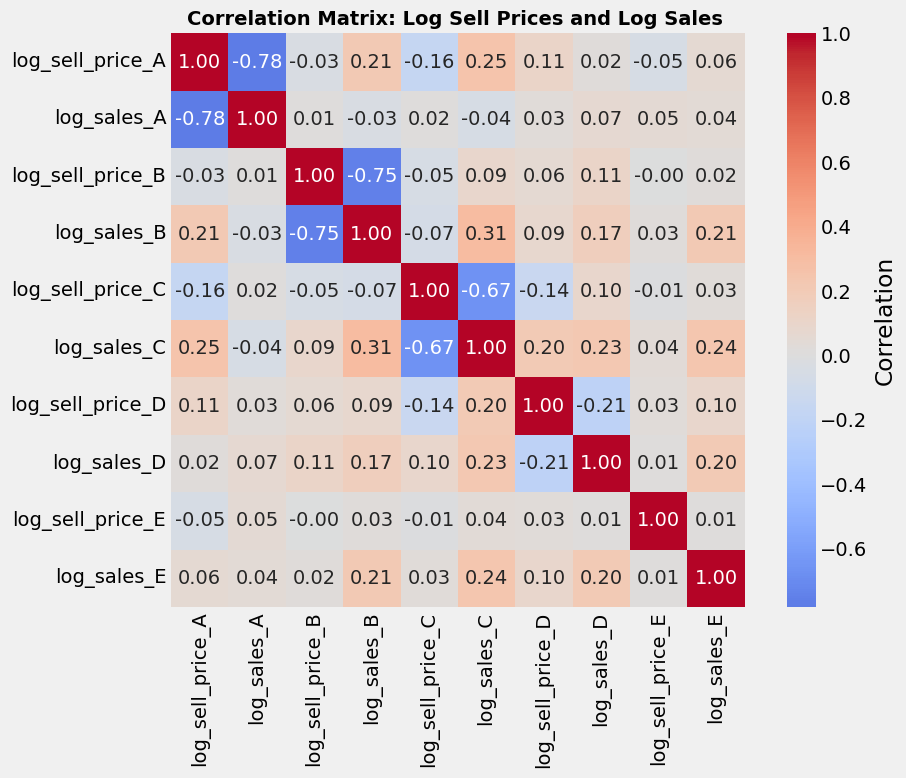

Log Sell Price and Log Sales Correlations:
                  log_sell_price_A  log_sales_A  log_sell_price_B  \
log_sell_price_A              1.00        -0.78             -0.03   
log_sales_A                  -0.78         1.00              0.01   
log_sell_price_B             -0.03         0.01              1.00   
log_sales_B                   0.21        -0.03             -0.75   
log_sell_price_C             -0.16         0.02             -0.05   
log_sales_C                   0.25        -0.04              0.09   
log_sell_price_D              0.11         0.03              0.06   
log_sales_D                   0.02         0.07              0.11   
log_sell_price_E             -0.05         0.05             -0.00   
log_sales_E                   0.06         0.04              0.02   

                  log_sales_B  log_sell_price_C  log_sales_C  \
log_sell_price_A         0.21             -0.16         0.25   
log_sales_A             -0.03              0.02        -0.04   
log_s

In [31]:
df_corr_daily = sa.log_correlation_plot(df_merge_daily)

In [ ]:
df_merge_daily

,sell_price_A,margin_A,sales_A,revenue_A,cost_A,log_sell_price_A,log_sales_A,log_revenue_A,sell_price_B,margin_B,...,log_sales_D,log_revenue_D,sell_price_E,margin_E,sales_E,revenue_E,cost_E,log_sell_price_E,log_sales_E,log_revenue_E
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,82.39,24.72,19.0,1565.41,57.67,4.423528,2.995732,7.356542,36.19,10.86,...,0.693147,3.804215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02,82.39,24.72,41.0,3377.99,57.67,4.423528,3.737670,8.125332,36.19,10.86,...,1.098612,4.486161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,82.39,24.72,66.0,5437.74,57.67,4.423528,4.204693,8.601303,36.19,10.86,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,82.39,24.72,77.0,6344.03,57.67,4.423528,4.356709,8.755427,36.19,10.86,...,1.791759,5.395671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-05,82.39,24.72,77.0,6344.03,57.67,4.423528,4.356709,8.755427,36.19,10.86,...,1.945910,5.577236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-23,98.89,29.67,32.0,3164.48,69.22,4.604070,3.496508,8.060060,38.39,11.52,...,1.791759,5.513227,219.89,65.97,131.0,28805.59,153.92,5.397665,4.882802,10.268359
2021-01-24,98.89,29.67,29.0,2867.81,69.22,4.604070,3.401197,7.961653,38.39,11.52,...,2.995732,6.845252,219.89,65.97,187.0,41119.43,153.92,5.397665,5.236442,10.624260
2021-01-25,98.89,29.67,53.0,5241.17,69.22,4.604070,3.988984,8.564491,38.39,11.52,...,2.079442,5.848546,219.89,65.97,226.0,49695.14,153.92,5.397665,5.424950,10.813683


In [20]:
log_dependent_cols = [
    'log_sales_A', 'log_sales_B', 'log_sales_C',
    'log_sales_D', 'log_sales_E'
]
regression_columns = {}
# df_corr.loc['log_sales_A'][np.abs(df_corr.loc['log_sales_A']) > 0.5].drop('log_sales_A')
for col in log_dependent_cols:
    independent_variables = []
    corr_cols = df_corr_daily.loc[col][np.abs(df_corr_daily.loc[col]) > 0.5].drop(col)
    print(f"Columns correlated with {col} (|corr| > 0.5):")
    if len(corr_cols) == 0:
        print(f"  {col} is not correlated with any of the given values")
    else:
        for c, val in corr_cols.items():
            regression_columns.setdefault(col, []).append(c)
            print(f"  {c}: {val:.4f}")
    print('*'*30)
print("Regression Columns Dictionary:")
print(regression_columns)

Columns correlated with log_sales_A (|corr| > 0.5):
  log_sell_price_A: -0.7804
******************************
Columns correlated with log_sales_B (|corr| > 0.5):
  log_sell_price_B: -0.7490
******************************
Columns correlated with log_sales_C (|corr| > 0.5):
  log_sell_price_C: -0.6680
******************************
Columns correlated with log_sales_D (|corr| > 0.5):
  log_sales_D is not correlated with any of the given values
******************************
Columns correlated with log_sales_E (|corr| > 0.5):
  log_sales_E is not correlated with any of the given values
******************************
Regression Columns Dictionary:
{'log_sales_A': ['log_sell_price_A'], 'log_sales_B': ['log_sell_price_B'], 'log_sales_C': ['log_sell_price_C']}


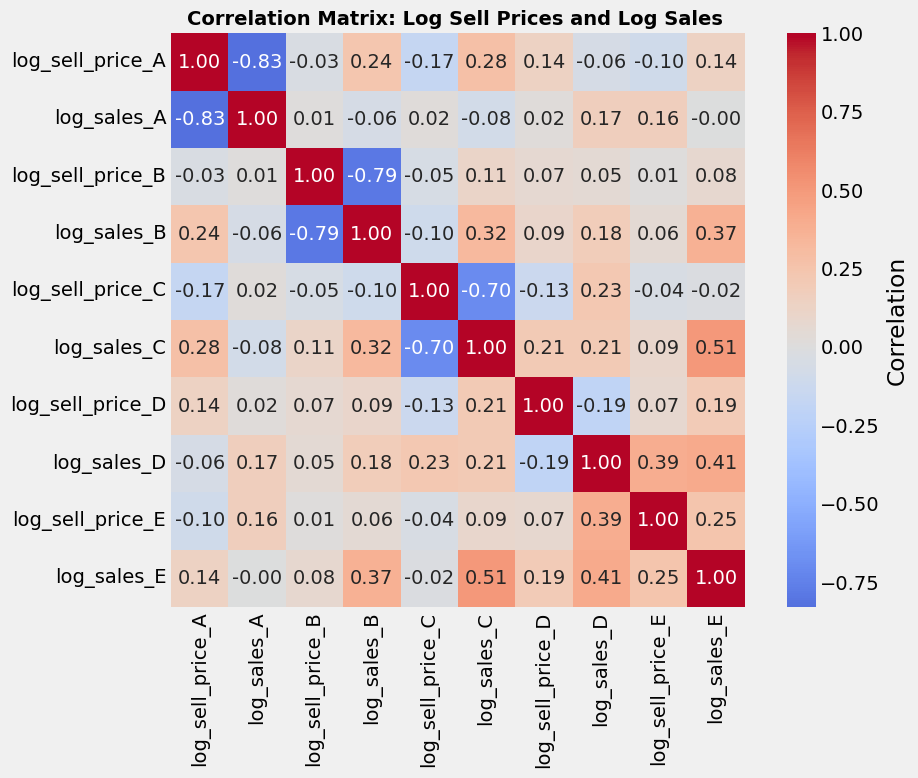

Log Sell Price and Log Sales Correlations:
                  log_sell_price_A  log_sales_A  log_sell_price_B  \
log_sell_price_A              1.00        -0.83             -0.03   
log_sales_A                  -0.83         1.00              0.01   
log_sell_price_B             -0.03         0.01              1.00   
log_sales_B                   0.24        -0.06             -0.79   
log_sell_price_C             -0.17         0.02             -0.05   
log_sales_C                   0.28        -0.08              0.11   
log_sell_price_D              0.14         0.02              0.07   
log_sales_D                  -0.06         0.17              0.05   
log_sell_price_E             -0.10         0.16              0.01   
log_sales_E                   0.14        -0.00              0.08   

                  log_sales_B  log_sell_price_C  log_sales_C  \
log_sell_price_A         0.24             -0.17         0.28   
log_sales_A             -0.06              0.02        -0.08   
log_s

In [13]:
df_corr_weekly = sa.log_correlation_plot(df_merge_weekly)

In [21]:
log_dependent_cols = [
    'log_sales_A', 'log_sales_B', 'log_sales_C',
    'log_sales_D', 'log_sales_E'
]
regression_columns = {}
# df_corr.loc['log_sales_A'][np.abs(df_corr.loc['log_sales_A']) > 0.5].drop('log_sales_A')
for col in log_dependent_cols:
    corr_cols = df_corr_weekly.loc[col][np.abs(df_corr_weekly.loc[col]) > 0.5].drop(col)
    print(f"Columns correlated with {col} (|corr| > 0.5):")
    if len(corr_cols) == 0:
        print(f"  {col} is not correlated with any of the given values")
    else:
        for c, val in corr_cols.items():
            regression_columns.setdefault(col, []).append(c)
            print(f"  {c}: {val:.4f}")
    print('*'*30)
print("Regression Columns Dictionary:")
print(regression_columns)

Columns correlated with log_sales_A (|corr| > 0.5):
  log_sell_price_A: -0.8288
******************************
Columns correlated with log_sales_B (|corr| > 0.5):
  log_sell_price_B: -0.7870
******************************
Columns correlated with log_sales_C (|corr| > 0.5):
  log_sell_price_C: -0.6960
  log_sales_E: 0.5061
******************************
Columns correlated with log_sales_D (|corr| > 0.5):
  log_sales_D is not correlated with any of the given values
******************************
Columns correlated with log_sales_E (|corr| > 0.5):
  log_sales_C: 0.5061
******************************
Regression Columns Dictionary:
{'log_sales_A': ['log_sell_price_A'], 'log_sales_B': ['log_sell_price_B'], 'log_sales_C': ['log_sell_price_C', 'log_sales_E'], 'log_sales_E': ['log_sales_C']}


In [ ]:
df_merge = sf.create_temporal_features(df_merge)
# df_merge.sample(10)

# OLS

In [22]:
def linear_regression_statsmodels(fdf, product ='A',other_products_flag = False  ,temporal_columns_flag=False):
    """
    Perform OLS regression using statsmodels to predict log_sales_{product} from df_model.
    """
    temporal_col_names = [ 'dayofmonth', 'month', 'year','is_weekend'] #'dayofweek',
    # 'dayofyear' and 'month' are correlated - exclude 'dayofyear'
    col_name_product = [f'log_sales_{product}']
    col_name_product_price = [f'log_sell_price_{product}']
    col_names_price = [ 'log_sell_price_A','log_sell_price_B','log_sell_price_C','log_sell_price_D','log_sell_price_E']
    if other_products_flag == False:
        col_names_price = col_name_product_price
    if temporal_columns_flag == False:
        temporal_col_names = []
    df_model = fdf[col_name_product+col_names_price+temporal_col_names].copy(deep=True)
    print(f"Running OLS regression for product: {product}")
    print("-"*70)
    print(df_model.columns.tolist())
    # Use df_model
    df_work = df_model.copy(deep=True)

    target = f'log_sales_{product}'
    if target not in df_work.columns:
        raise KeyError(f"{target} not found in df_model columns: {df_work.columns.tolist()}")

    # Select numeric features (exclude target)
    X = df_work.select_dtypes(include=["number"]).drop(columns=[target], errors='ignore')
    y = df_work[target]

    # Drop rows with NaNs
    mask = X.notna().all(axis=1) & y.notna()
    X = X.loc[mask]
    y = y.loc[mask]

    # Remove constant columns
    X = X.loc[:, X.std() > 0]

    print(f"Target: {target}")
    print(f"Number of observations: {len(y)}")
    print(f"Features ({len(X.columns)}): {X.columns.tolist()}")

    # Fit OLS
    X_sm = sm.add_constant(X)
    model = sm.OLS(y, X_sm)
    results = model.fit()
    beta0, beta1 = results.params[0], results.params[1]

    print("\n" + "="*70)
    print("STATSMODELS OLS REGRESSION SUMMARY")
    print("="*70)
    print(results.summary())

    # Store results
    _sm_ols_results = results
    
    return _sm_ols_results, beta0, beta1


In [24]:
lr_results = linear_regression_statsmodels(df_merge_daily, product ='A')


Running OLS regression for product: A
----------------------------------------------------------------------
['log_sales_A', 'log_sell_price_A']
Target: log_sales_A
Number of observations: 755
Features (1): ['log_sell_price_A']

STATSMODELS OLS REGRESSION SUMMARY
                            OLS Regression Results                            
Dep. Variable:            log_sales_A   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     1173.
Date:                Mon, 15 Dec 2025   Prob (F-statistic):          1.07e-155
Time:                        21:47:21   Log-Likelihood:                -474.25
No. Observations:                 755   AIC:                             952.5
Df Residuals:                     753   BIC:                             961.8
Df Model:                           1                                         
Covariance Type:         

/tmp/ipykernel_24321/3216780893.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta0, beta1 = results.params[0], results.params[1]


We have used **power-law demand function:**
$$ ln(q) = \beta_0 + \beta_1 ln(p) $$
$$ q(p) = e^{\beta_0} e^{\beta_1 ln(p)} = e^{\beta_0} e^{ln(p^{\beta_1})} = e^{\beta_0} p^{\beta1} $$
$$R(p) = p \times q(p) = e^{\beta_0} \times p^{\beta_1 + 1}$$
Using FOC (to maximize revenue):
$$\frac{dR}{dp} = 0 \implies \frac{e^{\beta_0} \times p^{\beta_1 + 1}}{dp} = 0$$
$$\implies \beta_1 = -1$$



In [26]:
data = df_merge_daily[['sell_price_A','sales_A','log_sales_A','log_sell_price_A']].copy(deep=True)
data = data.rename(
    columns={
        'sell_price_A':'price','sales_A':'sales',
        'log_sell_price_A':'ln_price','log_sales_A':'ln_sales'
        }
    )
print(data.shape)
data = data.dropna()
print(data.shape)
# Fit log–log regression
X = sm.add_constant(data['ln_price'])
model = sm.OLS(data['ln_sales'], X).fit()
beta0, beta1 = model.params

print("Regression coefficients:")
print(f"β0 = {beta0:.4f}, β1 = {beta1:.4f}")


(757, 4)
(755, 4)
Regression coefficients:
β0 = 19.0534, β1 = -3.3033


In [27]:
# Demand function
def demand(p):
    return np.exp(beta0) * p**beta1

# Revenue function
def revenue(p):
    return p * demand(p)


In [28]:
# We maximize revenue numerically within a sensible range
res = minimize_scalar(lambda p: -revenue(p),
                      bounds=(min(data['price']), max(data['price'])*5),
                      method='bounded')

optimal_price = res.x
max_revenue = revenue(optimal_price)

print(f"Optimal price: {optimal_price:.2f}")
print(f"Max revenue: {max_revenue:.2f}")
print(f"Sales: {max_revenue/optimal_price:.2f}")

Optimal price: 54.89
Max revenue: 18541.60
Sales: 337.80


In [30]:
linear_regression_statsmodels(df_merge_daily, product ='B')

Running OLS regression for product: B
----------------------------------------------------------------------
['log_sales_B', 'log_sell_price_B']
Target: log_sales_B
Number of observations: 739
Features (1): ['log_sell_price_B']

STATSMODELS OLS REGRESSION SUMMARY
                            OLS Regression Results                            
Dep. Variable:            log_sales_B   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     942.0
Date:                Mon, 15 Dec 2025   Prob (F-statistic):          6.65e-134
Time:                        21:48:07   Log-Likelihood:                -655.43
No. Observations:                 739   AIC:                             1315.
Df Residuals:                     737   BIC:                             1324.
Df Model:                           1                                         
Covariance Type:         

/tmp/ipykernel_24321/3216780893.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta0, beta1 = results.params[0], results.params[1]


(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f14e8dafd10>,
 np.float64(21.476336812018832),
 np.float64(-4.8643329559915935))

In [ ]:
linear_regression_statsmodels(df_merge, product ='C')

In [ ]:
linear_regression_statsmodels(df_merge, product ='D')

In [ ]:
linear_regression_statsmodels(df_merge, product ='E')

In [ ]:

def plot_price_sales(fdf, product_name):
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    print("Here")

    # Plot sales over time
    axes[0].plot(fdf.index, fdf[f'log_sales_{product_name}'], marker='o', linestyle='-', linewidth=2)
    axes[0].set_title(f'{product_name} - Log Sales Over Time', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Log Sales')
    axes[0].grid(True, alpha=0.3)

    # Plot sell_price over time
    axes[1].plot(fdf.index, fdf[f'log_sell_price_{product_name}'], marker='s', linestyle='-', linewidth=2, color='orange')
    axes[1].set_title(f'{product_name} - Log Sell Price Over Time', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Log Sell Price')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


In [ ]:
plot_price_sales(df_merge, 'A')
# plot_price_sales(df_merge, 'B')
# plot_price_sales(df_merge, 'C')
# plot_price_sales(df_merge, 'D')
plot_price_sales(df_merge, 'E')

In [ ]:
# Plot log sales for all products
fig, axes = plt.subplots(5, 1, figsize=(14, 12))
products = ['A', 'B', 'C', 'D', 'E']
dfs = [df_product_A, df_product_B, df_product_C, df_product_D, df_product_E]

for idx, (product, df_prod) in enumerate(zip(products, dfs)):
    axes[idx].plot(df_prod.index, df_prod[f'log_sales_{product}'], marker='o', linestyle='-', linewidth=2, color=f'C{idx}')
    axes[idx].set_title(f'Product {product} - Log Sales Over Time', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Log Sales')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Plot log sales for all products - 2019 only
fig, axes = plt.subplots(5, 1, figsize=(14, 12))
products = ['A', 'B', 'C', 'D', 'E']
dfs = [df_product_A, df_product_B, df_product_C, df_product_D, df_product_E]

for idx, (product, df_prod) in enumerate(zip(products, dfs)):
    df_2019 = df_prod[df_prod.index.year == 2019]
    axes[idx].plot(df_2019.index, df_2019[f'log_sales_{product}'], marker='o', linestyle='-', linewidth=2, color=f'C{idx}')
    axes[idx].set_title(f'Product {product} - Log Sales Over Time (2019)', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Log Sales')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Plot log sales for all products - 2020 only
fig, axes = plt.subplots(5, 1, figsize=(14, 12))
products = ['A', 'B', 'C', 'D', 'E']
dfs = [df_product_A, df_product_B, df_product_C, df_product_D, df_product_E]

for idx, (product, df_prod) in enumerate(zip(products, dfs)):
    df_2020 = df_prod[df_prod.index.year == 2020]
    axes[idx].plot(df_2020.index, df_2020[f'log_sales_{product}'], marker='o', linestyle='-', linewidth=2, color=f'C{idx}')
    axes[idx].set_title(f'Product {product} - Log Sales Over Time (2020)', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Log Sales')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
def plot_price_sales_correlation(df_product, product_name):
    # Correlation plot between sell_price and sales
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.scatter(df_product['log_price'], df_product['log_sales'], alpha=0.6, s=50, color='steelblue')
    ax.set_xlabel('Log Sell Price', fontsize=12, fontweight='bold')
    ax.set_ylabel('Log Sales', fontsize=12, fontweight='bold')
    ax.set_title(f'{product_name} - Correlation between Log Sell Price and Log Sales', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)

    # Add correlation coefficient
    corr = df_product['log_price'].corr(df_product['log_sales'])
    ax.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax.transAxes, 
            fontsize=11, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()

# plot_price_sales_correlation(df_product_A, 'Product A')
# plot_price_sales_correlation(df_product_B, 'Product B')
# plot_price_sales_correlation(df_product_C, 'Product C')
# plot_price_sales_correlation(df_product_D, 'Product D')
plot_price_sales_correlation(df_product_E, 'Product E')

In [ ]:
# # Day-wise boxplot of sales
# fig, axes = plt.subplots(2, 3, figsize=(15, 10))
# axes = axes.flatten()

# products = [df_product_A, df_product_B, df_product_C, df_product_D, df_product_E]
# product_names = ['Product A', 'Product B', 'Product C', 'Product D', 'Product E']
# days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# for idx, (df_product, product_name) in enumerate(zip(products, product_names)):
#     # Prepare data for boxplot
#     data_by_day = [df_product[df_product['dayofweek'] == day]['sales'].values for day in range(7)]
    
#     bp = axes[idx].boxplot(data_by_day, labels=days, patch_artist=True)
    
#     # Color the boxes
#     for patch in bp['boxes']:
#         patch.set_facecolor('lightblue')
    
#     axes[idx].set_title(f'{product_name} - Day-wise Sales Distribution', fontsize=11, fontweight='bold')
#     axes[idx].set_xlabel('Day of Week')
#     axes[idx].set_ylabel('Sales')
#     axes[idx].grid(True, alpha=0.3, axis='y')

# # Hide the extra subplot
# axes[5].set_visible(False)

# plt.tight_layout()
# plt.show()


In [ ]:
# # Day-wise boxplot of sell_price
# fig, axes = plt.subplots(2, 3, figsize=(15, 10))
# axes = axes.flatten()

# products = [df_product_A, df_product_B, df_product_C, df_product_D, df_product_E]
# product_names = ['Product A', 'Product B', 'Product C', 'Product D', 'Product E']
# days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# for idx, (df_product, product_name) in enumerate(zip(products, product_names)):
#     # Prepare data for boxplot
#     data_by_day = [df_product[df_product['dayofweek'] == day]['sell_price'].values for day in range(7)]
    
#     bp = axes[idx].boxplot(data_by_day, labels=days, patch_artist=True)
    
#     # Color the boxes
#     for patch in bp['boxes']:
#         patch.set_facecolor('lightcoral')
    
#     axes[idx].set_title(f'{product_name} - Day-wise Price Distribution', fontsize=11, fontweight='bold')
#     axes[idx].set_xlabel('Day of Week')
#     axes[idx].set_ylabel('Sell Price')
#     axes[idx].grid(True, alpha=0.3, axis='y')

# # Hide the extra subplot
# axes[5].set_visible(False)

# plt.tight_layout()
# plt.show()


In [ ]:
# # Requirements: statsmodels, scikit-learn
# # pip install statsmodels scikit-learn

# import numpy as np
# import pandas as pd
# import statsmodels.api as sm
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import r2_score

# # Replace with your merged dataframe variable if different
# df_work = df_merge.copy()

# target = 'log_sales_A'   # dependent variable
# if target not in df_work.columns:
#     raise KeyError(f"{target} not found in dataframe columns: {df_work.columns.tolist()}")

# # Build X: numeric columns except the target
# X = df_work.select_dtypes(include=[np.number]).drop(columns=[target], errors='ignore')
# y = df_work[target]

# # Drop rows with NaNs in X or y
# mask = X.notna().all(axis=1) & y.notna()
# X = X.loc[mask]
# y = y.loc[mask]

# # (Optional) remove perfectly collinear or constant columns
# X = X.loc[:, X.std() > 0]

# # --- OLS (statsmodels) ---
# X_sm = sm.add_constant(X)         # adds intercept term
# model = sm.OLS(y, X_sm)
# results = model.fit()
# print("OLS summary:")
# print(results.summary())

# # --- Train/test linear regression (scikit-learn) ---
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# lr = LinearRegression()
# lr.fit(X_train, y_train)
# y_pred = lr.predict(X_test)
# print("\nSklearn LinearRegression R^2 on test set:", r2_score(y_test, y_pred))

# # Show coefficients (aligned to feature names)
# coefs = pd.Series(lr.coef_, index=X.columns)
# print("\nCoefficients (sklearn LR):")
# print(coefs.sort_values(ascending=False).head(20))

In [ ]:
# # Compact regression summary, save full OLS to file, and run CV (R^2 and MAE)
# from pathlib import Path
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import make_scorer, mean_absolute_error
# import numpy as np

# out_dir = Path('results')
# out_dir.mkdir(exist_ok=True)
# summary_path = out_dir / 'regression_summary.txt'

# # Retrieve stored results
# res = globals().get('_regression_results', None)
# if res is None:
#     raise RuntimeError("_regression_results not found. Run the regression cell first.")

# selected_features = res.get('selected_features', [])
# lr = res.get('sklearn_lr')
# lasso = res.get('lasso_model')
# sm_res = res.get('statsmodels_results')

# # Compact print
# print('Selected features ({}):'.format(len(selected_features)))
# print(selected_features)

# # Top coefficients from sklearn LR
# if lr is not None:
#     coefs = pd.Series(lr.coef_, index=selected_features)
#     print('\nTop coefficients (sklearn LR):')
#     print(coefs.sort_values(key=lambda s: s.abs(), ascending=False).head(10))
# else:
#     print('\nNo sklearn LR model found in _regression_results')

# # Test R^2: try to compute if test split stored (not stored). We'll recompute a quick train/test split for a compact R^2.
# try:
#     X_imp = globals().get('X_imp')
#     y = globals().get('y')
#     if X_imp is None or y is None:
#         # try to rebuild minimal X_imp,y from df_merge
#         df_work = globals().get('df_merge')
#         if df_work is None:
#             raise RuntimeError('df_merge not found for recomputing test R^2')
#         # use selected features from df_merge (impute median)
#         X_temp = df_work[selected_features].copy()
#         X_temp = X_temp.fillna(X_temp.median())
#         y_temp = df_work['log_sales_A'].loc[X_temp.index]
#     else:
#         X_temp = X_imp[selected_features].copy()
#         y_temp = y.loc[X_temp.index]

#     from sklearn.model_selection import train_test_split
#     X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)
#     lr_tmp = LinearRegression()
#     lr_tmp.fit(X_train, y_train)
#     y_pred = lr_tmp.predict(X_test)
#     test_r2 = r2_score(y_test, y_pred)
#     print(f"\nCompact test R^2 (recomputed): {test_r2:.4f}")
# except Exception as e:
#     print('\nCould not recompute compact test R^2:', e)

# # Cross-validated scores
# try:
#     X_cv = X_temp
#     y_cv = y_temp
#     # R^2 CV
#     cv_r2 = cross_val_score(LinearRegression(), X_cv, y_cv, cv=5, scoring='r2')
#     # MAE CV (negative MAE returned by scikit-learn with scoring that expects higher is better)
#     neg_mae = cross_val_score(LinearRegression(), X_cv, y_cv, cv=5, scoring='neg_mean_absolute_error')
#     cv_mae = -neg_mae
#     print(f"\nCV R^2 (5-fold): mean={cv_r2.mean():.4f}, std={cv_r2.std():.4f}")
#     print(f"CV MAE (5-fold): mean={cv_mae.mean():.4f}, std={cv_mae.std():.4f}")
# except Exception as e:
#     print('\nCV evaluation failed:', e)

# # Save full OLS summary to file
# try:
#     with open(summary_path, 'w') as f:
#         f.write('Selected features:\n')
#         f.write('\n'.join(selected_features) + '\n\n')
#         f.write('Sklearn coefficients (top 50):\n')
#         if lr is not None:
#             coef_lines = coefs.sort_values(key=lambda s: s.abs(), ascending=False).head(50).to_string()
#             f.write(coef_lines + '\n\n')
#         f.write('Statsmodels OLS summary:\n')
#         if sm_res is not None:
#             f.write(str(sm_res.summary()) + '\n')
#         else:
#             f.write('No statsmodels results found')
#     print(f"\nFull OLS summary saved to {summary_path}")
# except Exception as e:
#     print('\nFailed to write summary file:', e)


In [ ]:
# # Multicollinearity check: correlation pairs, VIF, and condition number
# from pathlib import Path
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# import numpy as np
# import pandas as pd

# product = 'A'
# temporal_col_names =['dayofweek', 'dayofmonth','dayofyear', 'month', 'year','is_weekend']
# col_name_product = [f'log_sales_{product}']
# col_names_price = [ 'log_sell_price_A','log_sell_price_B','log_sell_price_C','log_sell_price_D','log_sell_price_E']
# df_model = df_merge[col_name_product+col_names_price+temporal_col_names].copy(deep=True)
# out_dir = Path('results')
# out_dir.mkdir(exist_ok=True)

# # Choose working dataframe: df_model (as built earlier)
# df_work = globals().get('df_model', None)
# if df_work is None:
#     raise RuntimeError('df_model not found in notebook namespace')

# # target may be log_sales_A — exclude target from features
# target = f'log_sales_{product}'
# if target in df_work.columns:
#     X = df_work.drop(columns=[target])
# else:
#     X = df_work.copy()

# # Keep numeric columns only
# X_num = X.select_dtypes(include=[np.number]).copy()
# if X_num.shape[1] == 0:
#     raise RuntimeError('No numeric features found to compute multicollinearity')

# # Impute median for any missing values to allow VIF computation
# imp = SimpleImputer(strategy='median')
# X_imp = pd.DataFrame(imp.fit_transform(X_num), index=X_num.index, columns=X_num.columns)

# # Compute correlation matrix and list high-correlation pairs
# corr = X_imp.corr()
# threshold = 0.8
# high_pairs = []
# cols = X_imp.columns.tolist()
# for i in range(len(cols)):
#     for j in range(i+1, len(cols)):
#         v = corr.iloc[i, j]
#         if abs(v) >= threshold:
#             high_pairs.append((cols[i], cols[j], float(v)))

# # Save correlation matrix and high pairs
# corr.to_csv(out_dir / 'correlation_matrix.csv')
# with open(out_dir / 'high_corr_pairs.txt', 'w') as f:
#     f.write(f'Pairs with |corr| >= {threshold}\n')
#     for a,b,v in high_pairs:
#         f.write(f'{a}\t{b}\t{v:.4f}\n')

# # Prepare X for VIF: add constant not needed for VIF calculation
# # Remove constant / zero-variance columns
# stds = X_imp.std()
# non_const = stds[stds > 0].index.tolist()
# X_vif = X_imp[non_const]

# # Standardize before computing condition number
# scaler = StandardScaler()
# X_scaled = pd.DataFrame(scaler.fit_transform(X_vif), index=X_vif.index, columns=X_vif.columns)

# # Compute VIFs
# vifs = []
# for i, col in enumerate(X_vif.columns):
#     try:
#         vif_val = variance_inflation_factor(X_vif.values, i)
#     except Exception as e:
#         vif_val = np.nan
#     vifs.append((col, float(vif_val)))

# vif_df = pd.DataFrame(vifs, columns=['feature', 'VIF']).sort_values('VIF', ascending=False)
# vif_df.to_csv(out_dir / 'vif.csv', index=False)

# # Condition number (of X'X)
# cond_number = np.linalg.cond(X_scaled)

# # Compact printout
# print('Multicollinearity check — compact summary')
# print('-'*60)
# print(f'Number of numeric features: {X_num.shape[1]}')
# print(f'High-correlation pairs (|corr| >= {threshold}): {len(high_pairs)}')
# for a,b,v in high_pairs[:10]:
#     print(f'  {a} — {b}: {v:.3f}')
# if len(high_pairs) > 10:
#     print(f'  ... and {len(high_pairs)-10} more')

# print('\nTop VIFs:')
# print(vif_df.head(10).to_string(index=False))
# print(f'\nCondition number (scaled X): {cond_number:.3f}')
# print('\nSaved:')
# print(f' - correlation matrix -> {out_dir / "correlation_matrix.csv"}')
# print(f' - high correlation pairs -> {out_dir / "high_corr_pairs.txt"}')
# print(f' - VIFs -> {out_dir / "vif.csv"}')

# # Expose variables for later inspection
# _vif_df = vif_df
# _high_corr_pairs = high_pairs
# _cond_number = cond_number
# _corr_matrix = corr


In [ ]:
# Density plot for df_merge['log_sell_price_E']
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure column exists and drop NA values
col = 'log_sell_price_E'
if col not in df_merge.columns:
    raise KeyError(f"{col} not found in df_merge columns: {df_merge.columns.tolist()}")

data = df_merge[col].dropna()
if data.shape[0] == 0:
    print(f'No non-null values found for {col}')
else:
    plt.figure(figsize=(8,5))
    sns.kdeplot(data, fill=True, bw_method='scott', color='C0')
    plt.title('Density plot: log_sell_price_E', fontsize=14, fontweight='bold')
    plt.xlabel('log_sell_price_E')
    plt.ylabel('Density')
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

# Product E

In [ ]:
df_product_E.dropna(inplace=True)
df_product_E['revenue_E'] = df_product_E['sell_price_E'] * df_product_E['sales_E']
df_product_E

In [ ]:
mode_E = df_product_E['log_sell_price_E'].mode()
print(type(mode_E))
print(mode_E.iloc[0] )
df_product_E['flag_discount_E'] = np.where(
    df_product_E['log_sell_price_E'] < mode_E.iloc[0]*0.98, 1, 0
)
df_product_E['percentage_discount_E'] =  (mode_E.iloc[0] - df_product_E['log_sell_price_E']) / mode_E.iloc[0] * 100
df_product_E['percentage_discount_E'].value_counts()

In [ ]:

# Create continuous week column for df_product_E (based on elapsed time from earliest date)
min_date = df_product_E.index.min()
df_product_E['week'] = np.ceil((df_product_E.index - min_date).days / 7).astype(int)
# Ensure week starts at 1 (not 0)
df_product_E['week'] = df_product_E['week'] + 1
print(f"Week column created. Min date: {min_date}, Unique weeks: {sorted(df_product_E['week'].unique())}")
# print(df_product_E[['week']].head(15))

In [ ]:
df_product_E

In [ ]:
col_names = ['sell_price_E','sales_E','log_sales_E','log_sell_price_E','flag_discount_E','week']
data = df_product_E[col_names].copy(deep=True)
data = data.rename(
    columns={
        'sell_price_E':'price','sales_E':'sales',
        'log_sell_price_E':'ln_price','log_sales_E':'ln_sales'
        }
    )
print(data.shape)
data = data.dropna()
print(data.shape)
# Fit log–log regression
X = sm.add_constant(data['week'])
model = sm.OLS(data['ln_sales'], X).fit()
beta0, beta1 = model.params

print("Regression coefficients:")
print(f"β0 = {beta0:.4f}, β1 = {beta1:.4f}")


In [ ]:
data['is_weekend'] = (data['dayofweek'] >= 5).astype(int)

In [ ]:
def linear_regression_statsmodels(fdf, target_column_name, independent_variables_columns):
    """
    Perform OLS regression using statsmodels to predict log_sales_{product} from df_model.
    """
    df_model = fdf[[target_column_name] + independent_variables_columns].copy(deep=True)
    print(df_model.columns )
    print("-"*70)
    print(df_model.columns.tolist())
    # Use df_model
    df_work = df_model.copy(deep=True)

    target = target_column_name
    if target not in df_work.columns:
        raise KeyError(f"{target} not found in df_model columns: {df_work.columns.tolist()}")

    # Select numeric features (exclude target)
    X = df_work.select_dtypes(include=["number"]).drop(columns=[target], errors='ignore')
    y = df_work[target]

    # Drop rows with NaNs
    mask = X.notna().all(axis=1) & y.notna()
    X = X.loc[mask]
    y = y.loc[mask]

    # Remove constant columns
    X = X.loc[:, X.std() > 0]

    print(f"Target: {target}")
    print(f"Number of observations: {len(y)}")
    print(f"Features ({len(X.columns)}): {X.columns.tolist()}")

    # Fit OLS
    X_sm = sm.add_constant(X)
    model = sm.OLS(y, X_sm)
    results = model.fit()
    beta0, beta1 = results.params[0], results.params[1]

    print("\n" + "="*70)
    print("STATSMODELS OLS REGRESSION SUMMARY")
    print("="*70)
    print(results.summary())

    # Store results
    _sm_ols_results = results
    
    return _sm_ols_results, beta0, beta1


In [ ]:
independent_variables_columns = ['week','percentage_discount_E']
target_column_name = 'log_sales_E'
linear_regression_statsmodels(df_product_E, target_column_name, independent_variables_columns)

In [ ]:
independent_variables_columns = ['week','flag_discount_E']
target_column_name = 'log_sales_E'
linear_regression_statsmodels(df_product_E, target_column_name, independent_variables_columns)

In [ ]:
independent_variables_columns = ['week','log_sell_price_E']
target_column_name = 'log_sales_E'
linear_regression_statsmodels(df_product_E, target_column_name, independent_variables_columns)

In [ ]:
df_product_E.groupby('week')['sales_E'].sum().plot()

In [ ]:
df_product_E.groupby('week')['sell_price_E'].mean().plot()

In [ ]:
df_product_A['sell_price_A'].plot()